# Custum CosineAnnealingWarmRestarts
- https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annealing_warmup/scheduler.py

In [2]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, first_cycle_steps, cycle_mult = 1.0, max_lr = 0.1, min_lr = 0.001, warmup_steps = 0, gamma = 1.0, last_epoch = -1):
        # first_cycle_steps은 최초 주기, cycle_mult 다음 주기가 몇 배 늘어나는지
        # max_lr는 LR이 얼마까지 높아지는지, gamma는 주기 반복 시 max_lr에 곱해지는 값 (LR max를 줄이는 역할)
        # warmup_steps은 Warm up 시 필요한 epoch 수를 지정 (일반적으로 짧은 epoch 수를 지정)
        self.first_cycle_steps = first_cycle_steps
        self.cycle_mult = cycle_mult
        self.base_max_lr = max_lr                       # first max learning rate
        self.max_lr = max_lr                            # max learning rate in the current cycle
        self.min_lr = min_lr                            # min learning rate
        self.warmup_steps = warmup_steps                # warmup step size
        self.gamma = gamma                              # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps        # first cycle step size
        self.cycle = 0                                  # cycle count
        self.step_in_cycle = last_epoch                 # step size of the current cycle

        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
        # parameter에 저장된 LR을 처음 LR로 저장
    
    def get_lr(self):
        if self.step_in_cycle == -1:                    # 첫 시작일 때
            return self.base_lrs                        # 그냥 base LR을 반영
        elif self.step_in_cycle < self.warmup_steps:    # 현재 epoch이 warmup_steps (warm up 단계) 안일 때
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
            # 첫 시작 LR~최대 LR까지 선형으로 증가시키기
        else:                                           # warm up 단계 이후일 때
            return [base_lr + (self.max_lr - base_lr) * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]
            #cosine annealing을 적용

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

- Initial setting

In [8]:
import torch
import matplotlib.pyplot as plt

num_epochs = 150
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

- Case 1

1e-06
0.01250075
0.025000500000000002
0.03750025
0.05
0.04990486935494459
0.0496202014214287
0.04914816269431356
0.04849234567333732
0.047657741522022734
0.04665070208190908
0.04547889153120266
0.04415122805575289
0.0426778159762731
0.04106986884835864
0.03933962412055798
0.03750025
0.03556574523438662
0.03355083257307006
0.03147084671804048
0.029341617617584432
0.02717934999082008
0.025000500000000002
0.022821650009179927
0.02065938238241558
0.018530153281959533
0.016450167426929955
0.014435254765613388
0.012500750000000005
0.010661375879442022
0.00893113115164136
0.0073231840237269075
0.005849771944247112
0.004522108468797347
0.0033502979180909304
0.00234325847797727
0.001508654326662685
0.0008528373056864368
0.0003807985785713056
9.613064505540724e-05
1e-06


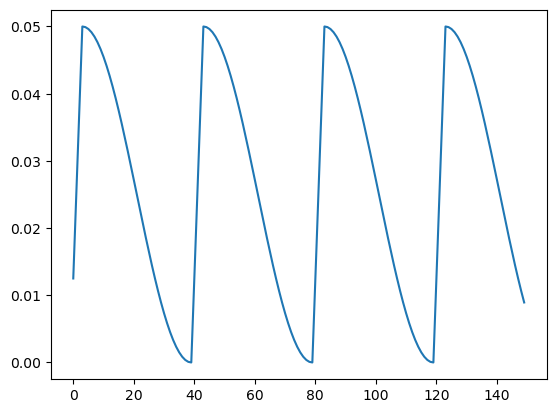

In [9]:
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, first_cycle_steps=40, cycle_mult = 1.0, max_lr = 0.05, min_lr = 0.000001, warmup_steps = 4, gamma = 1.0, last_epoch = -1)

lrs = []

for i in range(num_epochs):
    if i <= 40:
        print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)

- Case 2

1e-06
0.01250075
0.025000500000000002
0.03750025
0.05
0.04990486935494459
0.0496202014214287
0.04914816269431356
0.04849234567333732
0.047657741522022734
0.04665070208190908
0.04547889153120266
0.04415122805575289
0.0426778159762731
0.04106986884835864
0.03933962412055798
0.03750025
0.03556574523438662
0.03355083257307006
0.03147084671804048
0.029341617617584432
0.02717934999082008
0.025000500000000002
0.022821650009179927
0.02065938238241558
0.018530153281959533
0.016450167426929955
0.014435254765613388
0.012500750000000005
0.010661375879442022
0.00893113115164136
0.0073231840237269075
0.005849771944247112
0.004522108468797347
0.0033502979180909304
0.00234325847797727
0.001508654326662685
0.0008528373056864368
0.0003807985785713056
9.613064505540724e-05
1e-06


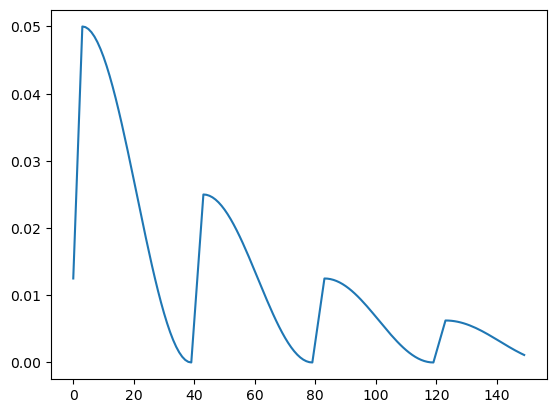

In [4]:
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, first_cycle_steps=40, cycle_mult = 1.0, max_lr = 0.05, min_lr = 0.000001, warmup_steps = 4, gamma = 0.5, last_epoch = -1)

lrs = []

for i in range(num_epochs):
    if i <= 40:
        print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)

- Case 3

1e-06
0.01250075
0.025000500000000002
0.03750025
0.05
0.04951964161744056
0.04809702637301592
0.045786824572757484
0.0426778159762731
0.03888947804037355
0.03456739446741106
0.029877660505242206
0.025000500000000002
0.020123339494757805
0.01543360553258894
0.01111152195962646
0.0073231840237269075
0.004214175427242518
0.0019039736269840873
0.00048135838255944087
1e-06
0.00625075
0.0125005
0.018750250000000003
0.025
0.024939811491039125
0.024759825612400182
0.024461775726484745
0.02404853221662483
0.023524074843722265
0.022893454418975667
0.02216274416180753
0.02133898121144125
0.02043009885540349
0.01944485012762852
0.018392723511956564
0.01728385156284744
0.016128913323342153
0.014939031480040596
0.013725665245549346
0.0125005


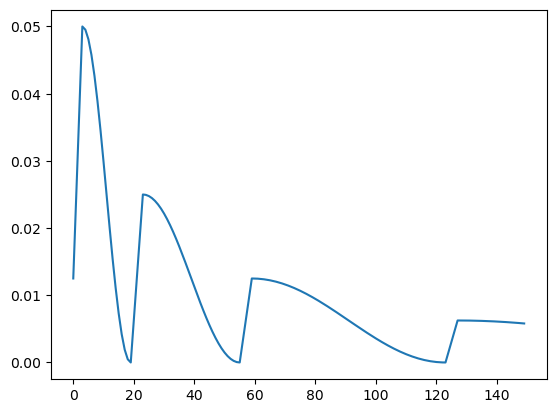

In [7]:
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, first_cycle_steps=20, cycle_mult = 2.0, max_lr = 0.05, min_lr = 0.000001, warmup_steps = 4, gamma = 0.5, last_epoch = -1)

lrs = []

for i in range(num_epochs):
    if i <= 40:
        print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)